In [1]:
import os
import itertools
import tempfile
import warnings
import pandas as pd
import qiime2 as q2
import numpy as np
from scipy.stats import ttest_ind, pearsonr, spearmanr
from biom import load_table, Table

#warnings.filterwarnings('ignore')

from skbio import TreeNode
from skbio import OrdinationResults
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix
from qiime2.plugins.gemelli.actions import ctf
from qiime2.plugins.emperor.actions import biplot
from qiime2.plugins.qurro.actions import (loading_plot,
                                          differential_plot,
                                          qarcoal)
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from assets.step_wise_anova import run_stepwise_anova
from qiime2.plugins.diversity.actions import beta_group_significance

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
%matplotlib inline

def temporal_plot(x_axis, y_axis, df, ax, title, x_label, y_label,
                  title_fontsize, x_fontsize, y_fontsize, hue=None,
                  style=None, size=None, min_x = 0, max_x = 35, err_style='band', 
                  ci=95, cmap='tab10', style_order=None, dashes_=True):

    """

    This wrapper creates beautiful timeseries plots using
    seaborn and matplotlib. 

    Parameters
    ----------
    x_axis : str, required
        X-axis catagory in dataframe -- data
        
    y_axis : str, required
        y-axis catagory in dataframe -- data
        
    df : dataframe, required
        dataframe of data to plot
    
    ax : matplotlib figure object, required
        panel object from matplotlib figure 
    
    title : str, required
        panel title
    
    x_label : str, required
        x label panel title
    
    y_label : str, required
        y label panel title
        
    title_fontsize : int, required
    x_fontsize : int, required
    y_fontsize : int, required
        font sizes 
    
    hue : str, optional
        color by catagory in dataframe -- data
        
    style : str, optional
        style by catagory in dataframe -- data
    
    Returns
    ----------
    matplotlib figure object

    """
    

    # Lineplot across time 
    sns.lineplot(x=x_axis,
                 y=y_axis,
                 hue=hue,
                 style=style,
                 dashes=dashes_,
                 ci=ci,
                 sort=True,
                 markers=style_order,
                 estimator=np.mean,
                 err_style=err_style,
                 palette=cmap,
                 data=df,
                 ax=ax)
    
    
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(x_label, color='#000000',
                  fontsize=x_fontsize)
    ax.set_ylabel(y_label, color='#000000',
                  fontsize=y_fontsize, labelpad=0)
    
    # remove all grids, backrounds etc ...
    ax.legend_.remove()        
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(min_x, max_x)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax


In [2]:
# import data
table = q2.Artifact.load('../data/16S/data-subsets/pma-treatment-table.qza')
sporemf = q2.Metadata.load('../data/bacdive-data/gg-sep-predicted.tsv')
metadata = q2.Metadata.load('../data/16S/data-subsets/pma-treatment-metadata.qza')
taxonomy = q2.Metadata.load('../data/16S/all-taxonomy.qza')
tree = q2.Artifact.load('../data/16S/insertion-tree.qza')

mf = metadata.to_dataframe()
x_org = 150
y_org = 600
radius = np.sqrt((x_org - mf['jpl_x'])**2\
                 + (y_org - mf['jpl_y'])**2)
mf['radius'] = radius.values
metadata = q2.Metadata(mf)

taxmf = taxonomy.to_dataframe()
spmf = sporemf.to_dataframe()
spmftax = pd.concat([taxmf, spmf], axis=1)
spmftax = spmftax.dropna(subset=['Spore'], axis=0)
spmftax.index.name = 'featureid'
sporemf = q2.Metadata(spmftax)


In [3]:
from skbio.stats.composition import closure

bt = table.view(Table)

#filter the table
_, n_samples = bt.shape
min_feature_frequency = 0
# filter features by N samples presence
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) \
            > (min_feature_frequency / 100)
# filter and import table for each filter above
bt = bt.filter(frequency_filter, axis='observation')
btdf = pd.DataFrame(bt.matrix_data.toarray(),
                    bt.ids('observation'), bt.ids())
sporemf_df = sporemf.to_dataframe()
mf = metadata.to_dataframe()
mf = mf.reindex(btdf.columns)
num = sporemf_df[(sporemf_df[['Spore_5','Spore_95']].sum(1).astype(int) != 2)
           & (sporemf_df['order'] == 'o__Rhizobiales')].index
den = sporemf_df[(sporemf_df['Spore_5'].astype(int) == 1)].index
num = btdf.loc[num, :].sum()
den = btdf.loc[den, :].sum()
lr = np.log(num) - np.log(den)
lr[~np.isfinite(lr)] = np.nan
mf['log_ratio'] = lr
mf['tot'] = btdf.sum().reindex(mf.index)


In [4]:
from matplotlib import cm



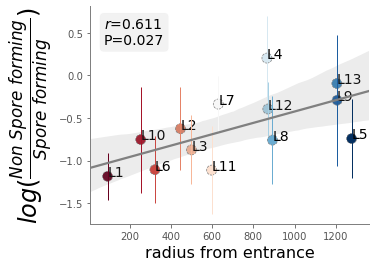

In [5]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

axis_1 = 'radius'
axis_2 = 'log_ratio'
hue = 'radius'
palette_ = 'RdBu'

lrdf_corr = mf.dropna(subset=['radius','log_ratio'])
lrdf_mean = lrdf_corr.groupby('jpl_location_area').mean().sort_values('radius')
lrdf_std = lrdf_corr.groupby('jpl_location_area').sem().sort_values('radius')
cmap = cm.get_cmap('RdBu', len(lrdf_mean.index))
cmap = [cmap(i) for i in range(cmap.N)]

# make scatter
kwargs  =   {'edgecolor':"gray",
             'linewidth':0.7,
             'linestyle':'--'}

ax.errorbar(lrdf_mean[axis_1].values,
            lrdf_mean[axis_2].values,
            yerr=lrdf_std[axis_2].values,
            ecolor=cmap,
            ms=0,
            lw=1,
            #zorder=-1,
            fmt='.k')

sns.scatterplot(x=axis_1, y=axis_2,
                hue='radius',
                s=100,
                palette=cmap,
                data=lrdf_mean,
                zorder=-1,
                ax=ax, **kwargs)


# reg line
sns.regplot(x=axis_1, y=axis_2,
           data=lrdf_mean,
           color='gray',
           ax=ax,
           scatter_kws={"s": 0})

r_, p_ = pearsonr(lrdf_mean['log_ratio'],
                  lrdf_mean['radius'])
textstr = '$r$=%.3f\nP=%.3f' % (r_, p_)
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='gray', alpha=0.1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# add dot annotation
for i in lrdf_mean.index:
    ax.text(lrdf_mean.loc[i, axis_1],
            lrdf_mean.loc[i, axis_2],
            str(i), zorder=-1,
            fontsize=14,
            color='black')

# Hide grid lines
ax.grid(False)
ax.set_facecolor('#f0f0f0')


# get axis labels
ax.set_ylabel('$log(\\frac{%s}{%s})$' % ('Non\,\,Spore\,\,forming','Spore\,\,forming'),
         fontsize=24, color='#000000')
ax.set_xlabel('radius from entrance',
         fontsize=16, color='#000000')
#ax.set_ylabel('%s (%.2f%%)' %\
#          (axis_2, p.loc[list(pc_cols).index(axis_2)] * 100),
#         fontsize=16, color='#000000')

# remove all grids, backrounds etc ...
ax.legend_.remove()        
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_bounds(min_x, max_x)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

# save the figure to file
plt.savefig('../results/figures/lr-spore-radius-corr.pdf',
            dpi=600, 
            bbox_inches='tight',
            edgecolor='none')
plt.show()

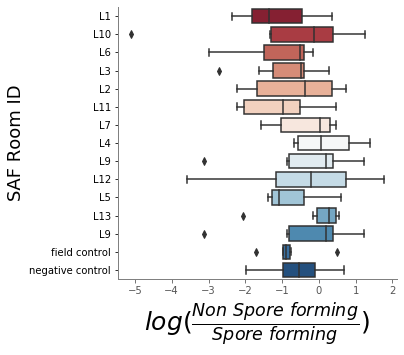

In [7]:
order_ = ['L1','L10','L6','L3','L2','L11','L7','L4','L9','L12',
          'L5','L13','L9','field control','negative control']
lrdf = mf.copy()
fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.boxplot(x='log_ratio', y='jpl_location_area',
            data=lrdf,palette='RdBu', order=order_, ax=ax)
# get axis labels
ax.set_xlabel('$log(\\frac{%s}{%s})$' % ('Non\,\,Spore\,\,forming','Spore\,\,forming'),
         fontsize=25, color='#000000')
ax.set_ylabel('SAF Room ID',
         fontsize=18, color='#000000')

ax.yaxis.label.set_color('black')
ax.tick_params(axis='y', colors='black')

# remove all grids, backrounds etc ...
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_bounds(min_x, max_x)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

# save the figure to file
plt.savefig('../results/figures/lr-spore-boxplot.pdf',
            dpi=600, 
            bbox_inches='tight',
            edgecolor='none')
        
plt.show()